In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [52]:
# CSV読み込み
df = pd.read_csv("/home/leon/study/mydir/MUFG-Data-Science-Challenge-2025/datasets/test_fixed.csv")

In [53]:
df = df[df['final_status'] == 0]

KeyError: 'final_status'

In [54]:
df.shape

(32439, 103)

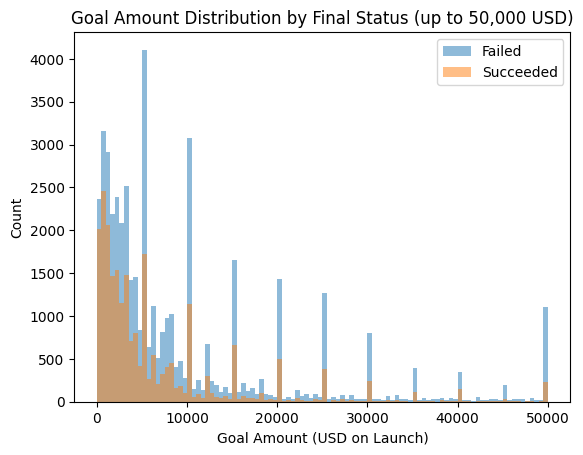

In [31]:
plt.hist(df[df["final_status"] == 0]["goal_usd_on_launch"], bins=100, range=(0, 50000), alpha=0.5, label="Failed")
plt.hist(df[df["final_status"] == 1]["goal_usd_on_launch"], bins=100, range=(0, 50000), alpha=0.5, label="Succeeded")
plt.xlabel("Goal Amount (USD on Launch)")
plt.ylabel("Count")
plt.title("Goal Amount Distribution by Final Status (up to 50,000 USD)")
plt.legend()
plt.show()


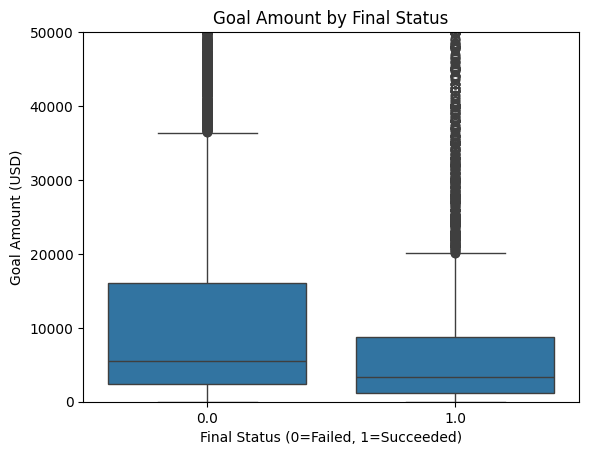

In [32]:
import seaborn as sns

sns.boxplot(x="final_status", y="goal_usd_on_launch", data=df)
plt.ylim(0, 50000)  # 上限を制限
plt.xlabel("Final Status (0=Failed, 1=Succeeded)")
plt.ylabel("Goal Amount (USD)")
plt.title("Goal Amount by Final Status")
plt.show()


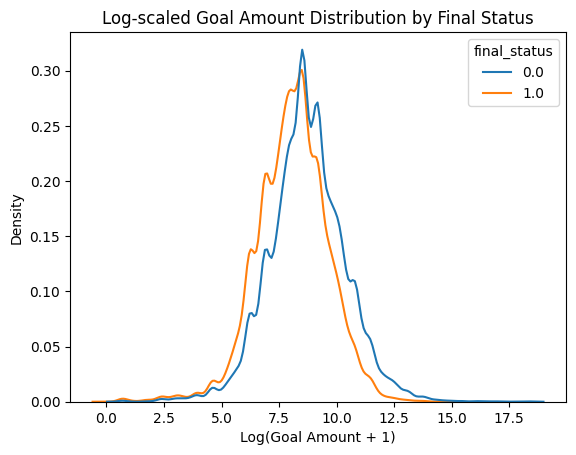

In [33]:
import numpy as np

df["log_goal"] = np.log1p(df["goal_usd_on_launch"])  # log(1+x)で0対策

sns.kdeplot(data=df, x="log_goal", hue="final_status", common_norm=False)
plt.xlabel("Log(Goal Amount + 1)")
plt.ylabel("Density")
plt.title("Log-scaled Goal Amount Distribution by Final Status")
plt.show()


/tmp/ipykernel_17747/1077131257.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  use.groupby("goal_bin")


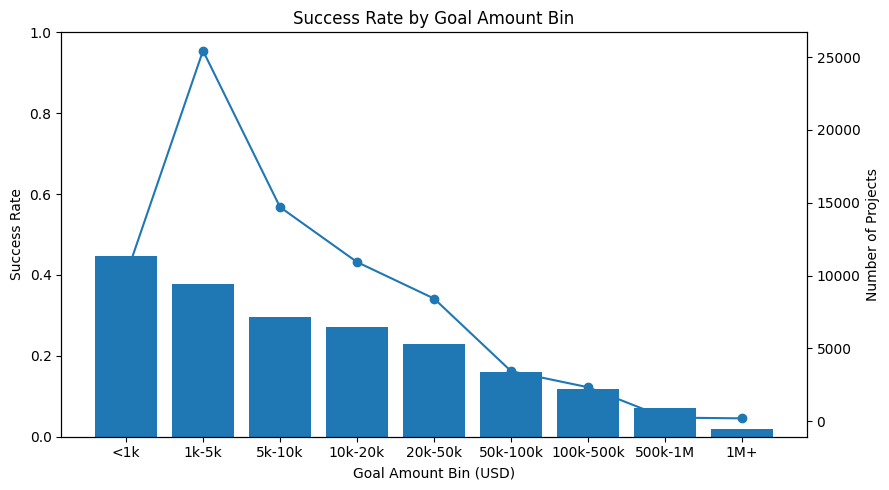

,success_rate,n_projects
goal_bin,,
<1k,0.447600,10000
1k-5k,0.378037,25434
5k-10k,0.296823,14699
10k-20k,0.270481,10925
20k-50k,0.229362,8419
50k-100k,0.160163,3434
100k-500k,0.117117,2331
500k-1M,0.071713,251
1M+,0.020305,197


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1) 前処理：必要列だけ使い、欠損を除去 ---
use = df[["goal_usd_on_launch", "final_status"]].dropna()

# --- 2) ビン定義（例）---
#   <1k, 1k-5k, 5k-10k, 10k-20k, 20k-50k, 50k-100k, 100k-500k, 500k-1M, 1M+）
bins   = [0, 1_000, 5_000, 10_000, 20_000, 50_000, 100_000, 500_000, 1_000_000, np.inf]
labels = ["<1k", "1k-5k", "5k-10k", "10k-20k", "20k-50k",
          "50k-100k", "100k-500k", "500k-1M", "1M+"]

use["goal_bin"] = pd.cut(use["goal_usd_on_launch"], bins=bins, labels=labels, include_lowest=True, right=False)

# --- 3) 成功率 & 件数の算出 ---
summary = (
    use.groupby("goal_bin")
       .agg(success_rate=("final_status", "mean"),
            n_projects=("final_status", "size"))
       .reindex(labels)  # ラベル順に並べる
)

# --- 4) 可視化：成功率の棒 + 件数の折れ線 ---
fig, ax1 = plt.subplots(figsize=(9,5))

# 成功率（0-1）を棒で
ax1.bar(summary.index.astype(str), summary["success_rate"])
ax1.set_ylim(0, 1)
ax1.set_ylabel("Success Rate")
ax1.set_xlabel("Goal Amount Bin (USD)")
ax1.set_title("Success Rate by Goal Amount Bin")

# 件数を第二軸で（規模感の参考）
ax2 = ax1.twinx()
ax2.plot(summary.index.astype(str), summary["n_projects"], marker="o")
ax2.set_ylabel("Number of Projects")

plt.tight_layout()
plt.show()

# （必要なら結果のテーブルも表示）
display(summary)


In [46]:
import numpy as np
import pandas as pd

# --- 1. 対数変換 ---
df["log_goal"] = np.log1p(df["goal_usd_on_launch"])  # log(1+x)で0対応

# --- 2. ビニング（カテゴリ分け）---
bins   = [0, 1e3, 5e3, 1e4, 2e4, 5e4, 1e5, 5e5, 1e6, np.inf]
labels = ["<1k", "1k-5k", "5k-10k", "10k-20k", "20k-50k",
          "50k-100k", "100k-500k", "500k-1M", "1M+"]
df["goal_bin"] = pd.cut(df["goal_usd_on_launch"], bins=bins, labels=labels, include_lowest=True)

# --- 3. 全体に対する分位ランク（0〜1の割合）---
df["goal_percentile"] = df["goal_usd_on_launch"].rank(pct=True)

# --- 4. カテゴリ別の中央値との比率 ---
if "category" in df.columns:
    df["goal_rel_to_category"] = df["goal_usd_on_launch"] / df.groupby("category")["goal_usd_on_launch"].transform("median")
else:
    df["goal_rel_to_category"] = np.nan  # category列がない場合は欠損扱い

# --- 5. 国別の中央値との比率 ---
if "country" in df.columns:
    df["goal_rel_to_country"] = df["goal_usd_on_launch"] / df.groupby("country")["goal_usd_on_launch"].transform("median")
else:
    df["goal_rel_to_country"] = np.nan

# --- 確認 ---
print(df[["goal_usd_on_launch", "log_goal", "goal_bin", "goal_percentile", "goal_rel_to_category", "goal_rel_to_country"]].head(10))


   goal_usd_on_launch   log_goal goal_bin  goal_percentile  \
0             11250.0   9.328212  10k-20k         0.724699   
1              2100.0   7.650169    1k-5k         0.285401   
2              2000.0   7.601402    1k-5k         0.264909   
3              4000.0   8.294300    1k-5k         0.432580   
4             40000.0  10.596660  20k-50k         0.904736   
5              2600.0   7.863651    1k-5k         0.332012   
6             16000.0   9.680406  10k-20k         0.789074   
7              4000.0   8.294300    1k-5k         0.432580   
8               250.0   5.525453      <1k         0.030189   
9               300.0   5.707110      <1k         0.037019   

   goal_rel_to_category  goal_rel_to_country  
0                   NaN                 2.25  
1                   NaN                 0.42  
2                   NaN                 0.40  
3                   NaN                 0.80  
4                   NaN                 8.00  
5                   NaN            

In [42]:
df.shape

(75690, 109)

In [47]:
print(df.columns.tolist())


['id', 'name', 'desc', 'goal', 'keywords', 'disable_communication', 'country', 'currency', 'deadline', 'state_changed_at', 'created_at', 'launched_at', 'final_status', 'launch_date', 'goal_usd_on_launch', 'created_at_ts', 'created_at_year', 'created_at_month', 'created_at_day', 'created_at_hour', 'created_at_minute', 'created_at_dow', 'created_at_doy', 'created_at_week', 'created_at_quarter', 'created_at_is_wkend', 'created_at_is_month_start', 'created_at_is_month_end', 'created_at_is_qtr_end', 'created_at_is_year_end', 'created_at_hour_sin', 'created_at_hour_cos', 'created_at_dow_sin', 'created_at_dow_cos', 'created_at_mon_sin', 'created_at_mon_cos', 'launched_at_ts', 'launched_at_year', 'launched_at_month', 'launched_at_day', 'launched_at_hour', 'launched_at_minute', 'launched_at_dow', 'launched_at_doy', 'launched_at_week', 'launched_at_quarter', 'launched_at_is_wkend', 'launched_at_is_month_start', 'launched_at_is_month_end', 'launched_at_is_qtr_end', 'launched_at_is_year_end', 'lau

In [55]:
import numpy as np
import pandas as pd

# 前提: df が既にあり、以下の列を持つ
# - goal_usd_on_launch : float/int（USD換算の目標金額）
# - country            : 国コード/国名（相対金額用）

# 1) 対数変換
df["log_goal"] = np.log1p(df["goal_usd_on_launch"])  # 0対応のlog(1+x)

# 2) レンジカテゴリ（ビン分け）
bins   = [0, 1_000, 5_000, 10_000, 20_000, 50_000, 100_000, 500_000, 1_000_000, np.inf]
labels = ["<1k", "1k-5k", "5k-10k", "10k-20k", "20k-50k",
          "50k-100k", "100k-500k", "500k-1M", "1M+"]
df["goal_bin"] = pd.cut(
    df["goal_usd_on_launch"],
    bins=bins, labels=labels,
    include_lowest=True, right=False
)

# 3) 全体順位（0〜1）
df["goal_percentile"] = df["goal_usd_on_launch"].rank(pct=True)

# 4) その国における相対目標額（国別中央値で割る）
if "country" in df.columns:
    med_cty = df.groupby("country")["goal_usd_on_launch"].transform("median")
    med_cty = med_cty.replace({0: np.nan})  # 0除算回避
    df["goal_rel_to_country"] = df["goal_usd_on_launch"] / med_cty
else:
    df["goal_rel_to_country"] = np.nan  # country列が無い場合

# 確認用
print(df[["goal_usd_on_launch", "log_goal", "goal_bin", "goal_percentile", "goal_rel_to_country"]].head())


   goal_usd_on_launch  log_goal goal_bin  goal_percentile  goal_rel_to_country
0             3500.00  8.160804    1k-5k         0.403064             0.700000
1             2748.33  7.919113    1k-5k         0.338081             0.500360
2            20000.00  9.903538  20k-50k         0.820062             4.000000
3             3500.00  8.160804    1k-5k         0.403064             0.700000
4              740.15  6.608203      <1k         0.106585             0.157365


In [56]:
df.shape

(32439, 107)

In [57]:
# 新しい特徴量を含めた df を CSVに保存する
output_path = "/home/leon/study/mydir/MUFG-Data-Science-Challenge-2025/datasets/test_fixed_v2.csv"
df.to_csv(output_path, index=False, encoding="utf-8")

print(f"保存しました: {output_path}")


保存しました: /home/leon/study/mydir/MUFG-Data-Science-Challenge-2025/datasets/test_fixed_v2.csv
